In [1]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")

using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using BARON

  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [2]:
innovations = CSV.File("./innovations.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./compromise.csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./initial.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
innovations[2,6]=7
innovations[2,2]=200
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,2,4.6,1.34,2.04,0.12,8.86,0
2,2,200,3,8.32,8.84,7.0,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,131,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [3]:
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Pkg.jl:570


Dict{String, VersionNumber} with 2 entries:
  "BARON" => v"0.6.5"
  "CPLEX" => v"0.7.8"

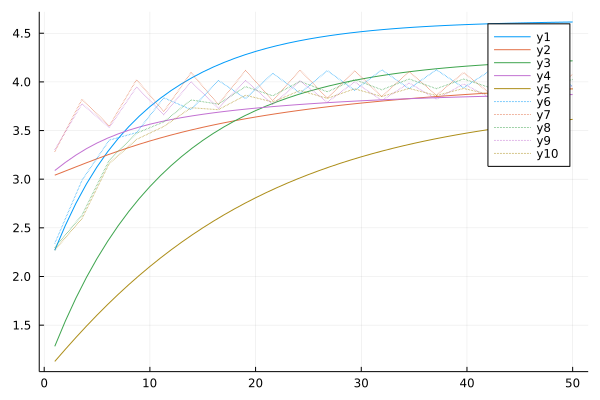

In [5]:
get_RL_atT(4,25)
pal = palette(:default)
plot([get_RL_atT.(i, 1:50) for i = 1:5]; color = [pal[i] for i = 1:5]')
plot!(range(1, 50; length = 20), [get_RL_DTMC.(i, 1:20) for i = 1:5], linestyle = :dot, color = pal[1:5]')

In [7]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],sigdigits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],sigdigits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),sigdigits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

1×5 Matrix{Int64}:
 1  2  3  4  5

In [9]:
function tech_roadmap()
    
    rdmap= Model(BARON.Optimizer)
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    @variable(rdmap, s[i=1:nrow(innovations)] )
    
    @variable(rdmap, co2_2050 ≥ 0)
    @variable(rdmap, co2_total ≥ 0)
    @variable(rdmap, 0≤ cost_inn)
    
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    @constraint(rdmap, [i=1], ti[i] ≤ sum(tk[k] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki)], ti[i] ≤ sum(tk[k] for k=mapki[i-1,2]:mapki[i,2]))
    
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    
    @constraint(rdmap, co2_2050==sum(xk[k]*compromise[k,3] for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    @variable(rdmap, eig_dec0[r=1:5,c=1,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec1[r=1:5,c=1:5,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec2[r=1:5,c=1:5,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec3[r=1,c=1:5,i=1:nrow(innovations)])
    
    @NLconstraint(rdmap,[r=1:5,i=1:nrow(innovations)],eig_dec0[r,1,i]==exp(d[r,1,i]*ti[i]))
    
    @NLconstraint(rdmap, [r=1:5,c=1:5,i=1:nrow(innovations)],eig_dec1[r,c,i]==(eig_dec0[r,1,i])*ainv[r,c,i])

    
    for r=1:5
        @NLconstraint(rdmap, [c=1:5,i=1:nrow(innovations)],eig_dec2[r,c,i]==sum(a[r,c1,i]*eig_dec1[c1,c,i] for c1 in 1:5))
    end
    
    @NLconstraint(rdmap,[c=1:5,i=1:nrow(innovations)],eig_dec3[1,c,i]==sum(s0[1,r,i]*eig_dec2[r,c,i] for r in 1:5))

    #@constraint(rdmap, sum(ti[i] for i in 1:nrow(innovations))≥ 10)
    #@NLparameter(rdmap, q[i=1:nrow(innovations)]==0)
    #@NLconstraint(rdmap, [i=1:nrow(innovations)], s[i]==sum([1 2 3 4 5].*((s0[:,:,i]*a[:,:,i]).*(exp.(d[:,:,i]*ti[i]))'*ainv[:,:,i])[ind] for ind in 1:5))
    @NLconstraint(rdmap, [i=1:nrow(innovations)], s[i]==sum(rl_vals[c]*eig_dec3[1,c,i] for c in 1:5))  
    #@constraint(rdmap, [i=1:nrow(innovations)], s[i]==s0[i])

    
    @constraint(rdmap, co2_2050 ≤ 75)
    @NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(5-s[i])*0.968^(-1*ti[i])) for i in 1:nrow(innovations)))
    @NLobjective(rdmap,Min, cost_inn)
    
    optimize!(rdmap)
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn)  
end




tech_roadmap (generic function with 1 method)

In [10]:
yk, tk, xk, yi, ti, s, co2, cost1=tech_roadmap()
yi

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value  250.269835950     
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             0.28

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 0.0

In [19]:
ti, co2

([0.0, 0.0, 0.0, 4.957105098974608, 0.0], 75.0)

In [20]:
tk

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 5.322881836331531
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## Additional functions

In [14]:

function get_latest(i,t)
    e0=zeros(5,1,i)
    e1=zeros(5,5,i)
    e2=zeros(5,5,i)
    e3=zeros(1,5,i)
    for r in 1:5
        e0[r,1,i]=exp(d[r,1,i]*t)
    end

    for r in 1:5
        for c in 1:5
            e1[r,c,i]=e0[r,1,i]*ainv[r,c,i]
        end
    end

    for r in 1:5
        for c in 1:5
            e2[r,c,i]=sum(a[r,c1,i]*e1[c1,c,i] for c1 in 1:5)
        end
    end

    for c in 1:5
        e3[1,c,i]=sum(s0[1,r,i]*e2[r,c,i] for r in 1:5)
    end


    e4=sum(rl_vals[c]*e3[1,c,i] for c in 1:5)

    #rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'
    return 5-e4
end

get_latest(50)
#rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'

LoadError: MethodError: no method matching get_latest(::Int64)
[0mClosest candidates are:
[0m  get_latest(::Any, [91m::Any[39m) at In[14]:2

In [13]:

plot(range(1, 50; length = 50),[0.968^(-1*i) for i = 1:50])
plot!(range(1, 50; length = 50), [get_latest.(1:50)])
plot!(range(1, 50; length = 50), [0.968^(-1*i)*get_latest.(2,i) for i = 1:50])

LoadError: UndefVarError: get_latest not defined

In [15]:
function get_new1(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    t1=(s0)*eigvecs(q)
    return t1
end
function get_new2(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    
    temp1=(eigvals(q))*t
    return temp1
end

function get_new3(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return inv(eigvecs(q_mat))
end


function get_new(i,t)
    return ([1 2 3 4 5]*(get_new1(i,t).*round.(exp.(get_new2(i,t)),sigdigits=3)'*get_new3(i,t))')
end
#get_RL(1,50)



i=1
t=50
s0=[0 0 0 0 0]
s0[rl[i]]=1
p_mat=reshape(collect(innovations[i,9:33]),5,5)'
q_mat=p_mat./collect(innovations[i,4:8])
for i in 1:5
    q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
end
q=q_mat
#rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
#rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
temp1=Diagonal(eigvals(q))*t
temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
d=eigvecs(q)*(temp2)*inv(eigvecs(q))
rl_t=sum([1 2 3 4 5].*(s0*d))
temp2

[exp(get_new2(4,50)[i]) for i in 1:5]
get_new1(4,50).*[exp(get_new2(4,50)[i]) for i in 1:5]
get_new2(4,50)[1]
get_new(4,50)

1×1 Matrix{Float64}:
 3.8698053730585023

In [16]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end

function calc_tot_co2(x,t)
    v=give_sorted(t)
    for i in 1:(size(tk)[1]-1)
        print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
        print("\n")
    end
    return 1
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    q=get_rate_mat(i)
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL_DTMC(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    rl_t=sum([1 2 3 4 5].*(s0*p_mat^t))
    return rl_t
end
    
    


get_RL_DTMC (generic function with 1 method)

In [17]:
g=exp(get_rate_mat(2)*50)


5×5 Matrix{Float64}:
 0.0771895  0.128895   0.138814   0.385642  0.269459
 0.0679296  0.114343   0.130868   0.400474  0.286385
 0.0452652  0.0776663  0.109623   0.437398  0.330047
 0.0280624  0.0499089  0.0930683  0.465243  0.363718
 0.0252328  0.0453331  0.0902223  0.46976   0.369452

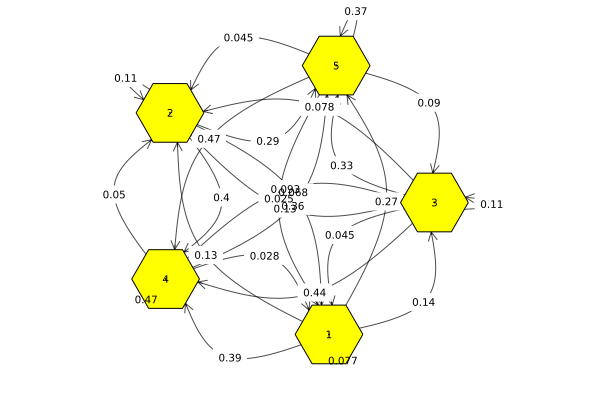

In [18]:
n = 5
edgelabel_dict = Dict()
edgelabel_mat = Array{String}(undef, n, n)
for i in 1:n
    for j in 1:n
        edgelabel_mat[i, j] = edgelabel_dict[(i, j)] = string(round(g[i,j],sigdigits=2)) 
    end
end
edgelabel_vec = edgelabel_mat[:]


graphplot(g, names=1:5, curvature_scalar=0.2,  edgelabel=edgelabel_dict, markersize = 0.5,
           linecolor = :darkgrey, markercolor = "yellow",
           linealpha = 0.7)